<a href="https://colab.research.google.com/github/Anot11/Time-Series-Analysis-using-NSW-Income./blob/main/Time_Series_Analysis%2C_Using_NSW_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 4.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
%reset -f

import pandas            as pd
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import numpy             as np

from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from scipy import stats
from sklearn import metrics

from datetime                    import datetime
from statsmodels.tsa.stattools   import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.api                 import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [3]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

In [4]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
df=pd.read_csv('/content/drive/MyDrive/NSWIncome.csv')

In [6]:
df.index = pd.date_range(start='1990', periods=31, freq='AS')
df.drop(['year'], axis=1, inplace=True)

In [7]:
df.head()

,Income
1990-01-01,32488
1991-01-01,32164
1992-01-01,29530
1993-01-01,28916
1994-01-01,30358


# Draw the time series graph of Income

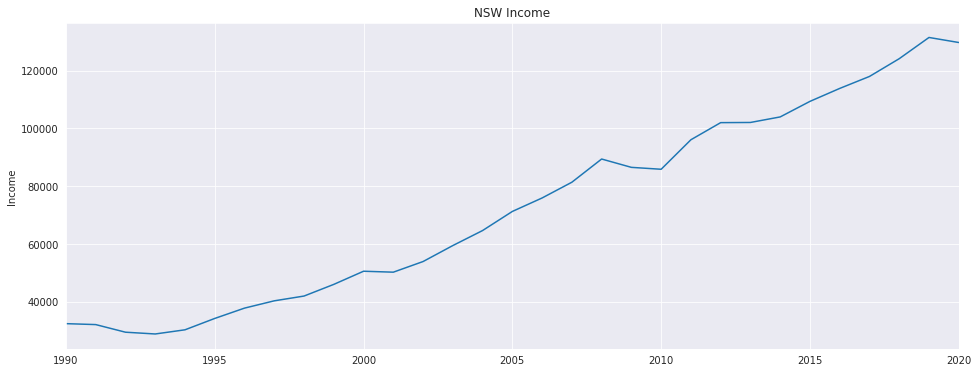

In [8]:
# (a) Draw the time series graph of Income


df['Income'].plot()
plt.ylabel("Income")

plt.title("NSW Income")
plt.show()

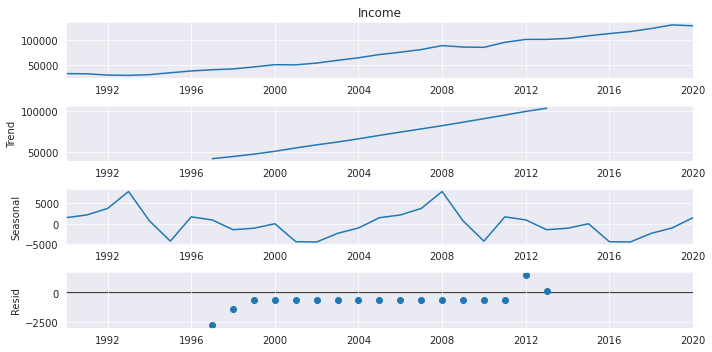

<Figure size 2880x720 with 0 Axes>

In [9]:
result = seasonal_decompose(df['Income'], model='additive', period=15)
 
rcParams['figure.figsize'] = 10, 5
result.plot()
plt.figure(figsize=(40,10))
plt.show()

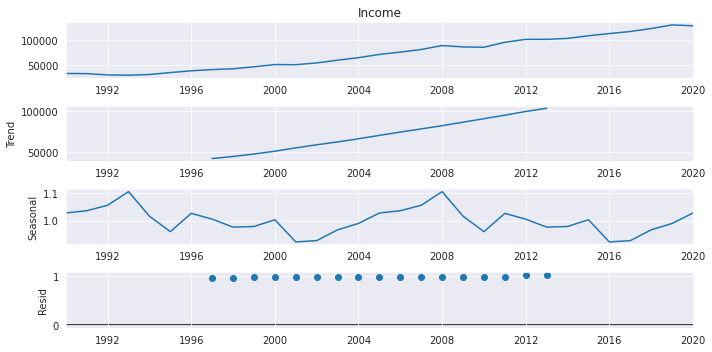

<Figure size 2880x720 with 0 Axes>

In [10]:
result = seasonal_decompose(df['Income'], model='multiplicative', period=15)
 
rcParams['figure.figsize'] = 10, 5
result.plot()
plt.figure(figsize=(40,10))
plt.show()

# Checking and testing second-order stataionary

In [11]:
df1 = pd.DataFrame()

df1['data'] = df['Income']

In [12]:
def plot_rolling(df,name):
    
    df['z_data'] = (df['data'] - df.data.rolling(window=4).mean()) / df.data.rolling(window=4).std()
    df['zp_data'] = df['z_data'] - df['z_data'].shift(1)
    df['zs_data'] = df['z_data'] - df['z_data'].shift(4)
    
    fig, ax = plt.subplots(4,figsize=(12, 9))
    ax[0].scatter(df.index, df.data, color='c', label=name)
    ax[0].plot(df.data.rolling(window=4).mean(), color='b', label="moving average");
    ax[0].plot(df.data.rolling(window=4).std(), color='r', label="moving std");
    ax[0].legend()

    ax[1].scatter(df.index, df.z_data, color='c', label="de-trended "+name)
    ax[1].plot(df.z_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[1].plot(df.z_data.rolling(window=4).std(), color='r', label="moving std");
    ax[1].legend()

    ax[2].scatter(df.index, df.zp_data, color='c', label="1 lag differenced de-trended "+name)
    ax[2].plot(df.zp_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[2].plot(df.zp_data.rolling(window=12).std(), color='r', label="moving std");
    ax[2].legend()
    
    ax[3].scatter(df.index, df.zs_data, color='c', label="seasonal differenced de-trended "+name)
    ax[3].plot(df.zs_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[3].plot(df.zs_data.rolling(window=4).std(), color='r', label="moving std");
    ax[3].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

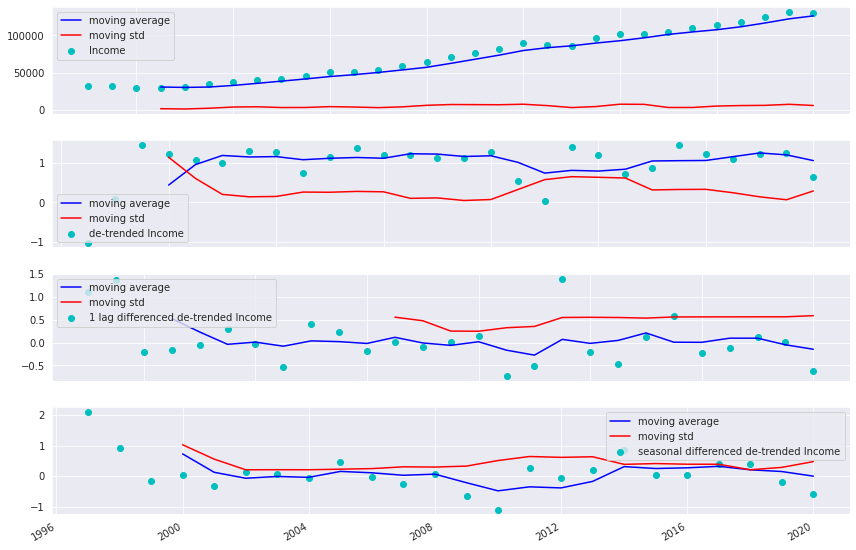

In [13]:
plot_rolling(df1,'Income')

In [14]:
# checking the second-order stataionary, unit root

def adf_test(df,name):
    
    print("-----------------------------------------")
    print("for variable " + name)
    print("-----------------------------------------")
    
    dftest = adfuller(df.data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
      print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    print("\n > Is the de-trended data stationary ?")
    dftest = adfuller(df.z_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
      print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    print("\n > Is the 1-lag differenced de-trended data stationary ?")
    dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
      print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
    print("\n > Is the seasonal differenced de-trended data stationary ?")
    dftest = adfuller(df.zs_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
      print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [15]:
adf_test(df1, 'Income')

-----------------------------------------
for variable Income
-----------------------------------------
Test statistic = 1.216
P-value = 0.996
Critical values :
	1%: -3.6889256286443146 - The data is not stationary with 99% confidence
	5%: -2.9719894897959187 - The data is not stationary with 95% confidence
	10%: -2.6252957653061224 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -6.826
P-value = 0.000
Critical values :
	1%: -3.7112123008648155 - The data is  stationary with 99% confidence
	5%: -2.981246804733728 - The data is  stationary with 95% confidence
	10%: -2.6300945562130176 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -7.716
P-value = 0.000
Critical values :
	1%: -3.7238633119999998 - The data is  stationary with 99% confidence
	5%: -2.98648896 - The data is  stationary with 95% confidence
	10%: -2.6328004 - The data is  stationary with 90% con

# Generate the first difference of Income

In [16]:
df1 =df['Income'].diff(1)
df1=df1.dropna()
df1

1991-01-01     -324.0
1992-01-01    -2634.0
1993-01-01     -614.0
1994-01-01     1442.0
1995-01-01     3931.0
1996-01-01     3571.0
1997-01-01     2522.0
1998-01-01     1653.0
1999-01-01     4035.0
2000-01-01     4550.0
2001-01-01     -328.0
2002-01-01     3680.0
2003-01-01     5529.0
2004-01-01     5196.0
2005-01-01     6604.0
2006-01-01     4660.0
2007-01-01     5446.0
2008-01-01     8026.0
2009-01-01    -2883.0
2010-01-01     -660.0
2011-01-01    10209.0
2012-01-01     5919.0
2013-01-01       60.0
2014-01-01     1917.0
2015-01-01     5377.0
2016-01-01     4480.0
2017-01-01     4142.0
2018-01-01     6144.0
2019-01-01     7341.0
2020-01-01    -1743.0
Freq: AS-JAN, Name: Income, dtype: float64

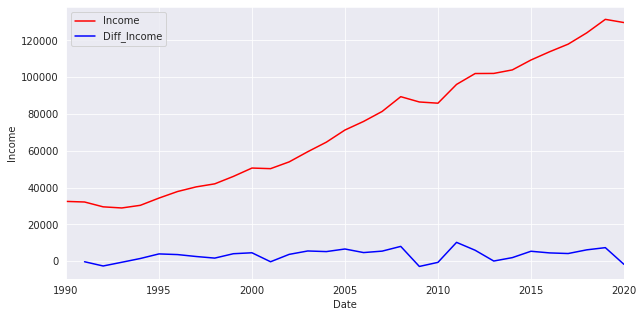

In [17]:
df['Income'].plot(label='Income',color='r')
df1.plot(label='Diff_Income',color='b')

plt.ylabel("Income")
plt.xlabel("Income")
plt.legend()
plt.ylabel("Income")
plt.xlabel("Date")
plt.show()

# ACF and plot of ACF of Diff_Income

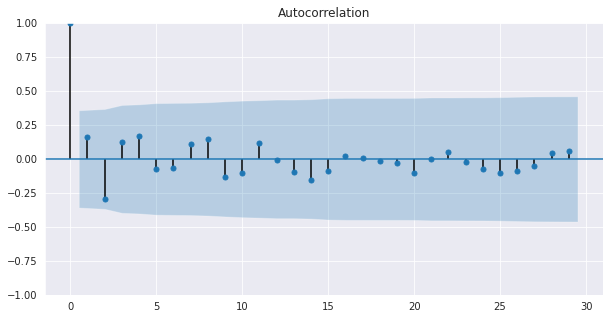

In [18]:
#(b) Find and plot the ACF of Delta_Income

sm.graphics.tsa.plot_acf(df1.values.squeeze(), lags=29)
plt.show()

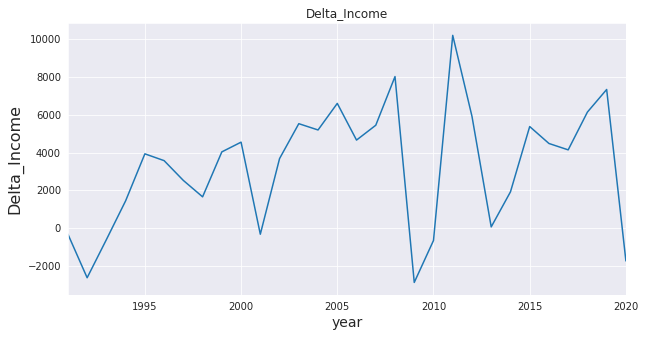

In [19]:
#Delta income alone

plt.title("Delta_Income")

plt.xlabel("year",fontsize=14)

plt.ylabel("Delta_Income",fontsize=16)

df1.plot()

In [20]:
df2 = df
df2['Income_D1'] = df2['Income'].diff(1)

df2 = df2.dropna(axis = 0)

In [21]:
df2

,Income,Income_D1
1991-01-01,32164,-324.0
1992-01-01,29530,-2634.0
1993-01-01,28916,-614.0
1994-01-01,30358,1442.0
1995-01-01,34289,3931.0
1996-01-01,37860,3571.0
1997-01-01,40382,2522.0
1998-01-01,42035,1653.0
1999-01-01,46070,4035.0
2000-01-01,50620,4550.0


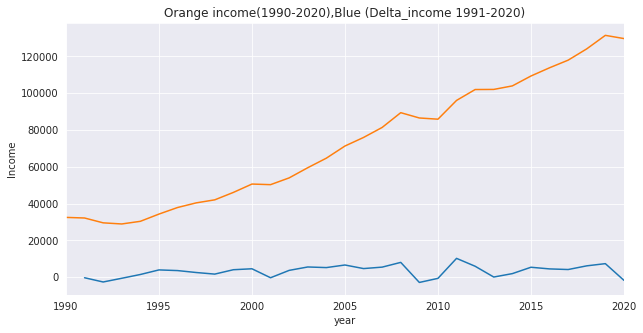

In [22]:
df2['Income_D1'].plot()

df['Income'].plot()

plt.xlabel("year")
plt.ylabel("Income")

plt.title("Orange income(1990-2020),Blue (Delta_income 1991-2020)")
plt.show()

#ARIMA model selection

In [23]:
#(b)propose an appropriate MA model for Delta_Income, estimate the model, and report the MA model with the estimated coefficients

mod = ARIMA(df2['Income_D1'], order=(0,0,1))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Income_D1   No. Observations:                   30
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -281.909
Date:                Sun, 18 Dec 2022   AIC                            569.818
Time:                        23:48:26   BIC                            574.021
Sample:                    01-01-1991   HQIC                           571.162
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3208.7973   1251.841      2.563      0.010     755.235    5662.360
ma.L1          0.8247      0.120      6.901      0.000       0.590       1.059
sigma2      8.159e+06   2.06e+06      3.953      0.0

In [24]:
#MA(2)

mod = ARIMA(df2['Income_D1'], order=(0,0,2))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Income_D1   No. Observations:                   30
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -280.219
Date:                Sun, 18 Dec 2022   AIC                            568.438
Time:                        23:48:27   BIC                            574.042
Sample:                    01-01-1991   HQIC                           570.231
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3235.1069    717.219      4.511      0.000    1829.384    4640.830
ma.L1          0.5697      0.441      1.291      0.197      -0.295       1.434
ma.L2         -0.4250      0.171     -2.479      0.0

In [25]:
#MA(3)

mod = ARIMA(df2['Income_D1'], order=(0,0,3))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Income_D1   No. Observations:                   30
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -280.213
Date:                Sun, 18 Dec 2022   AIC                            570.427
Time:                        23:48:27   BIC                            577.433
Sample:                    01-01-1991   HQIC                           572.668
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3251.5998    697.008      4.665      0.000    1885.490    4617.710
ma.L1          0.5775      0.386      1.495      0.135      -0.180       1.335
ma.L2         -0.4329      0.199     -2.175      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


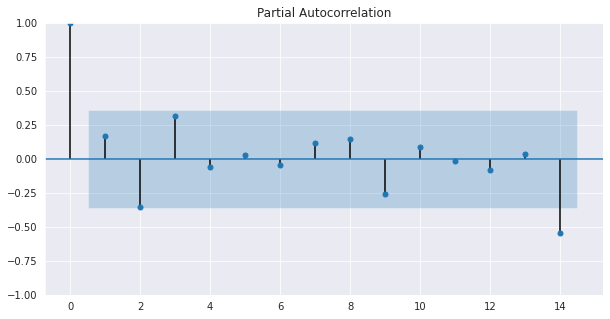

In [26]:
#Find and plot the PACF of 4Income, 
#propose an appropriate AR model for Delta_Income, estimate the model, and report the AR model with the estimated coefficients

sm.graphics.tsa.plot_pacf(df2['Income_D1'].values.squeeze(), lags=14)
plt.show()

In [27]:
#AR(1)

mod = ARIMA(df2['Income_D1'], order=(1,0,0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Income_D1   No. Observations:                   30
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -284.461
Date:                Sun, 18 Dec 2022   AIC                            574.922
Time:                        23:48:27   BIC                            579.126
Sample:                    01-01-1991   HQIC                           576.267
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3241.6000    701.840      4.619      0.000    1866.019    4617.181
ar.L1          0.1801      0.205      0.878      0.380      -0.222       0.582
sigma2      9.993e+06   3.36e+06      2.976      0.0

In [28]:
#AR(2)

mod = ARIMA(df2['Income_D1'], order=(2,0,0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Income_D1   No. Observations:                   30
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -282.107
Date:                Sun, 18 Dec 2022   AIC                            572.215
Time:                        23:48:27   BIC                            577.820
Sample:                    01-01-1991   HQIC                           574.008
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3241.6001    465.825      6.959      0.000    2328.600    4154.600
ar.L1          0.2639      0.243      1.087      0.277      -0.212       0.740
ar.L2         -0.4365      0.270     -1.614      0.1

In [29]:
#AR(3)

mod = ARIMA(df2['Income_D1'], order=(3,0,0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Income_D1   No. Observations:                   30
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -280.498
Date:                Sun, 18 Dec 2022   AIC                            570.997
Time:                        23:48:27   BIC                            578.003
Sample:                    01-01-1991   HQIC                           573.238
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3241.5999    800.380      4.050      0.000    1672.885    4810.315
ar.L1          0.4144      0.246      1.686      0.092      -0.067       0.896
ar.L2         -0.5051      0.282     -1.789      0.0

In [30]:
#AR(4)

mod = ARIMA(df2['Income_D1'], order=(4,0,0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Income_D1   No. Observations:                   30
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -280.260
Date:                Sun, 18 Dec 2022   AIC                            572.519
Time:                        23:48:27   BIC                            580.926
Sample:                    01-01-1991   HQIC                           575.209
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3241.6000    680.153      4.766      0.000    1908.524    4574.676
ar.L1          0.4727      0.240      1.970      0.049       0.002       0.943
ar.L2         -0.6036      0.294     -2.053      0.0

In [31]:
#AR(5)

mod = ARIMA(df2['Income_D1'], order=(5,0,0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Income_D1   No. Observations:                   30
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -279.971
Date:                Sun, 18 Dec 2022   AIC                            573.941
Time:                        23:48:27   BIC                            583.750
Sample:                    01-01-1991   HQIC                           577.079
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3241.5999    794.027      4.082      0.000    1685.336    4797.864
ar.L1          0.4869      0.291      1.672      0.095      -0.084       1.058
ar.L2         -0.6597      0.328     -2.009      0.0

In [32]:
#AR(6)

mod = ARIMA(df2['Income_D1'], order=(6,0,0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Income_D1   No. Observations:                   30
Model:                 ARIMA(6, 0, 0)   Log Likelihood                -279.718
Date:                Sun, 18 Dec 2022   AIC                            575.437
Time:                        23:48:28   BIC                            586.646
Sample:                    01-01-1991   HQIC                           579.023
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3241.6000    731.145      4.434      0.000    1808.583    4674.617
ar.L1          0.5124      0.258      1.990      0.047       0.008       1.017
ar.L2         -0.6903      0.328     -2.104      0.0

In [33]:
#AR(201)

mod = ARIMA(df2['Income_D1'], order=(2,0,1))
res_21 = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Income_D1   No. Observations:                   30
Model:                 ARIMA(6, 0, 0)   Log Likelihood                -279.718
Date:                Sun, 18 Dec 2022   AIC                            575.437
Time:                        23:48:28   BIC                            586.646
Sample:                    01-01-1991   HQIC                           579.023
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3241.6000    731.145      4.434      0.000    1808.583    4674.617
ar.L1          0.5124      0.258      1.990      0.047       0.008       1.017
ar.L2         -0.6903      0.328     -2.104      0.0

In [34]:
#AR(211)

mod = ARIMA(df2['Income_D1'], order=(2,1,1))
res_211 = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Income_D1   No. Observations:                   30
Model:                 ARIMA(6, 0, 0)   Log Likelihood                -279.718
Date:                Sun, 18 Dec 2022   AIC                            575.437
Time:                        23:48:28   BIC                            586.646
Sample:                    01-01-1991   HQIC                           579.023
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3241.6000    731.145      4.434      0.000    1808.583    4674.617
ar.L1          0.5124      0.258      1.990      0.047       0.008       1.017
ar.L2         -0.6903      0.328     -2.104      0.0

#Ljung and Box test

In [35]:
# For the selected and estimated model in , apply the Ljung and Box test
sm.stats.acorr_ljungbox(res_211.resid, lags=[27], return_df=True)

,lb_stat,lb_pvalue
27,20.110224,0.826099


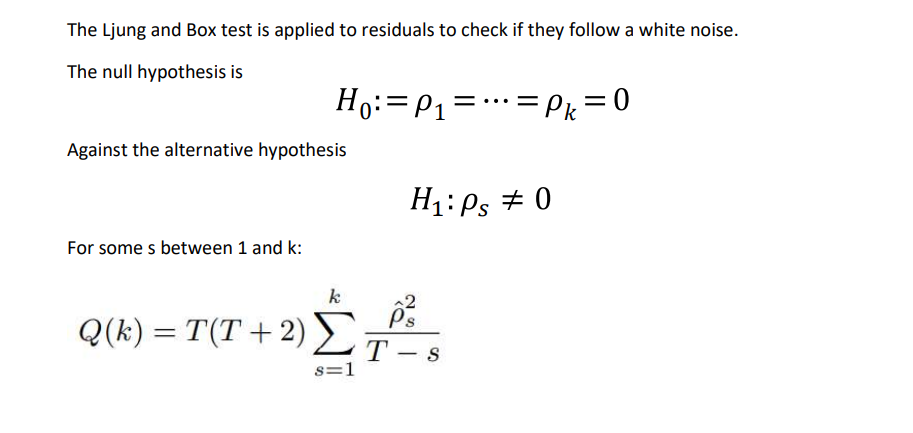

In [36]:
#Which follows a chi-squared distribution with (k − p − q) degrees of freedom for an ARMA(p,q) 
#model. The Ljung and Box is 20.11 with a p-value of 0.826 which is more then 0.05,
#thus we fail to reject the null hypothesis and conclude that the model is adequate

#Forecasting with ARMA

In [37]:
res_211.forecast(steps=10)

2021-01-01    1413.058562
2022-01-01    6909.842286
2023-01-01    4333.629466
2024-01-01    1074.859441
2025-01-01    3053.617901
2026-01-01    4939.947379
2027-01-01    3482.423003
2028-01-01    2422.076977
2029-01-01    3462.402301
2030-01-01    4036.104320
Freq: AS-JAN, Name: predicted_mean, dtype: float64